<a href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/04_01_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-Encoder to process spike waveforms

This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://772589be77c2ba3c6abd2e432e212f92d5f79998:@github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell
%load_ext tensorboard.notebook

Saving kaggle.json to kaggle.json
Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 551 (delta 92), reused 100 (delta 41), pack-reused 389
Receiving objects: 100% (551/551), 14.62 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (303/303), done.
     |████████████████████████████████| 332.1MB 48kB/s 
     |████████████████████████████████| 61kB 24.3MB/s 
     |████████████████████████████████| 419kB 47.1MB/s 
     |████████████████████████████████| 3.0MB 34.0MB/s 


In [4]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'vae_wf'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d guilmer/primate-pfc-spike-waveforms 
    print("Finished downloading. Now extracting contents...")
    data_path = Path('primate-pfc-spike-waveforms.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir)
    data_path.unlink()
    print("Finished extracting data.")
else:
    print("Data directory found. Skipping download.")

 90% 89.0M/98.6M [00:01<00:00, 45.9MB/s]
100% 98.6M/98.6M [00:01<00:00, 63.9MB/s]
Finished downloading. Now extracting contents...
Finished extracting data.


## Load data and plot a few examples to see what we're up against. 

This data was recorded from a 96 channel Utah Array in the lateral prefrontal cortex of a macaque monkey. 

Each channel was manually thresholded to remove invalid channels and to try to obtain the best isolated waveforms. 

Each waveform is 48 samples long, sampled  @ 30kHz for a duration of 1.6 ms. 

The data might still contain artefacts and some invalid waveforms.  

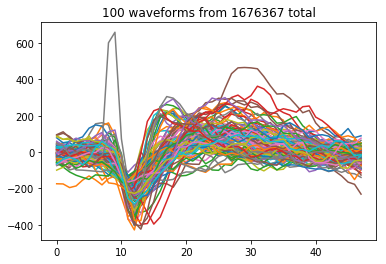

In [5]:
# Load data, convert to float-32 and add extra dim for tensorflow convolution layers
wf = np.load(os.path.join(datadir, 'waveforms.npy')).astype(np.float32)
wf = wf.reshape(wf.shape[0], wf.shape[1], 1)

# Plot 100 randomly selected waveforms
n_to_plot = 100
plt.figure(facecolor='white')
plt.plot(wf[np.random.randint(0, wf.shape[0], n_to_plot),:, 0].T)
plt.title(str(n_to_plot) + ' waveforms from ' + str(wf.shape[0]) + ' total');

## De-noising AE

In the previous session (03_01_Intro_to_CNNs.ipynb) we implemented a FIR filter from a convolution layer, and we added some noise to our input in order to get proper response in the high frequencies. In other words we modelled: 

$X + noise \rightarrow \hat{X}$

where $X$ is our input and $\hat{X}$ is our output, reconstructing the input minus the noise. This is a good example of a **de-noising AE**.

Let's implement another one to see it in more details. 


### Data pre-processing for deep learning

It's always a good idea to normalize your data in some way to restrict it's range roughly around $\pm 1$. 

We'll z-score. 

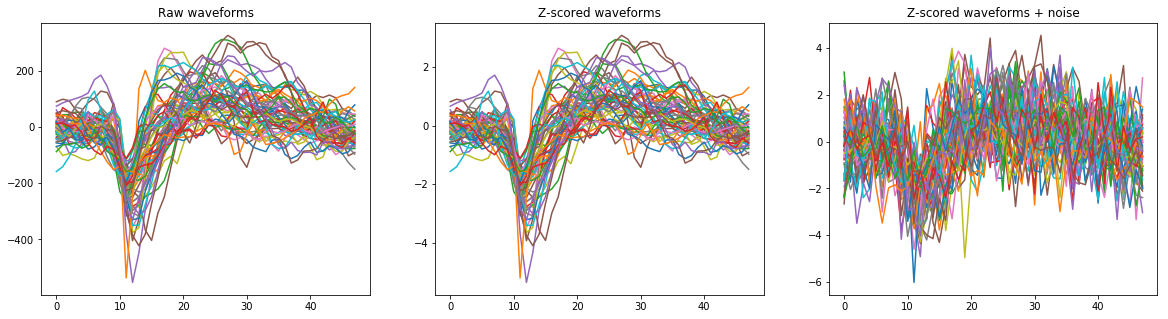

In [6]:
# Z-scoring the data
wf_mean = np.mean(wf)
wf_sd = np.std(wf)

z_wf = (wf-wf_mean) / wf_sd

plt.figure(facecolor='white', figsize=(20,5))
plt.subplot(131)
plt.plot(wf[::30000,:,0].T)
plt.title('Raw waveforms')
plt.subplot(132)
plt.plot(z_wf[::30000,:,0].T)
plt.title('Z-scored waveforms')
plt.subplot(133)
plt.plot((z_wf[::30000,:,0] + np.random.randn(z_wf[::30000,:,0].shape[0], z_wf[::30000,:,0].shape[1])).T)
plt.title('Z-scored waveforms + noise');

Even if we are not classifying the data, we need a validation set to make sure we are not over-fitting. We'll use 10000 randomly selected waveforms. 

In [0]:
# Validation set creation
n_test_waveforms = 10000
valid_idx = np.random.randint(0, z_wf.shape[0], n_test_waveforms)
valid_set = z_wf[valid_idx,:,:]

# Take only 50 000 waveforms to speed up training
n_train_waveforms = 50000
train_set = np.delete(z_wf, valid_idx, axis=0)
train_set = train_set[np.random.randint(0,train_set.shape[0], n_train_waveforms),:,:]


### Model Creation

In [0]:
# Model definition
# Fully annotated in VAE_SS_Validation notebook
# Data augmentation has been left out for now. 
class betaCVAE(tf.keras.Model):
  def __init__(self, latent_dim=2, beta=0., learning_rate=1e-2, capacity=0.):  # beta set to 1. is a default VAE

    super(betaCVAE, self).__init__()

    self.latent_dim = latent_dim
    self.beta = beta
    self.learning_rate = learning_rate
    self.capacity = capacity
    
    if self.beta > 0.:
      self.is_VAE = True
    else:
      self.is_VAE = False

    self.inference_net = tf.keras.Sequential(
          [
          tf.keras.layers.InputLayer(input_shape=(48, 1)),
          tf.keras.layers.Conv1D(filters=25, kernel_size=5, strides=1, activation=tf.nn.elu, padding='same'),  # output => 48 x 25
          tf.keras.layers.MaxPool1D(pool_size=2),  # output => 24 x 25
          tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1, activation=tf.nn.elu, padding='same'),  # output => 21 x 50
          tf.keras.layers.MaxPool1D(pool_size=2),  # output => 12 x 50    
          tf.keras.layers.Conv1D(filters=25, kernel_size=3, strides=1, activation=tf.nn.elu, padding='same'),  # output => 9 x 100
          tf.keras.layers.MaxPool1D(pool_size=2),  # output => 6 x 100
          tf.keras.layers.Flatten(),  # 600 x 1
          tf.keras.layers.Dense(100, activation=tf.nn.elu), # 100 x 1
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
      )


    self.generative_net = tf.keras.Sequential(
          [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(100, activation=tf.nn.elu),
          tf.keras.layers.Dense(300, activation=tf.nn.elu),
          tf.keras.layers.Reshape(target_shape=(6, 50)),
          tf.keras.layers.UpSampling1D(size=2),  # 12x50
          tf.keras.layers.Conv1D(filters=25, kernel_size=3, 
                                          strides=1, activation=tf.nn.elu, padding='same'),  # 12x100
          tf.keras.layers.UpSampling1D(size=2),  # 24x100
          tf.keras.layers.Conv1D(filters=25, kernel_size=3, 
                                          strides=1, activation=tf.nn.elu, padding='same'),  # 24x50
          tf.keras.layers.UpSampling1D(size=2),  # 48x50
          tf.keras.layers.Conv1D(filters=25, kernel_size=5, 
                                          strides=1, activation=tf.nn.elu, padding='same'),  # 48x25
          tf.keras.layers.Conv1D(filters=1, kernel_size=1, strides=1),   # 48x1
          ]
      )  

  def sample(self, eps=None):
      if eps is None:
          eps = tf.random_normal(shape=(100, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
      mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
      return mean, logvar

  def reparameterize(self, mean, logvar):
      eps = tf.random.normal(shape=mean.shape)
      return (eps * tf.exp(logvar * .5)) + mean

  def decode(self, z, apply_sigmoid=False):
      logits = self.generative_net(z)
      if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
      return logits

  def compute_loss(self, x, noisy_x):
    # Encoder part of the network
    if noisy_x is None:
      mean, log_var = self.encode(x)
    else:
      mean, log_var = self.encode(noisy_x)
      
    if self.is_VAE:
      z = self.reparameterize(mean, log_var)
    else:
      z = mean

    # Decoder
    x_decoded = self.decode(z)

    # Loss function from the QEDR paper by Eastwood and Williams 2018
    epsilon  = 1e-8
    
    # MSE
    recons_loss = tf.reduce_sum(tf.math.squared_difference(x, x_decoded), axis=1)
    recons_loss = tf.reduce_mean(recons_loss)
    
    
    # KLD
    latent_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    latent_loss = tf.reduce_mean(latent_loss)

    return tf.reduce_mean(recons_loss + self.beta * (tf.math.abs(latent_loss - self.capacity))), recons_loss, latent_loss
    

  def compute_gradients(self, x, noisy_x):
    with tf.GradientTape() as tape:
        loss, _, _ = self.compute_loss(x, noisy_x)
    return tape.gradient(loss, self.trainable_variables), loss

  @staticmethod
  def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))




# Implementation 1 

For now we'll simply create the model by calling the model creation function by using its default values. This is because our AE model has a few tricks up its sleeve and we haven't seen all the possible uses and parameters yet. 

The important parameters are: 

**ADD_NOISE**

> Setting this to `True` will add normally distributed noise to the data ($\mu = 0; SD = 1$). `False` will use the original data. Considering that the spike waveforms are already noisy, both approaches work well. Try either to see how good the model is. 

**Mini-batch size**

> Since our data is quite small (only 48 samples) we can use large batch sizes, but some caution should be used for mini-batch sizes [greater than
512](https://arxiv.org/abs/1606.02228). We can play with the values to trade-off between performance (large values) and model accuracy (small values), as larger batch sizes tend to make the model less precise. 

> For the sake of speed, we will use a high value of 1024, but feel free to try other values. Setting it to 2048 increases speed but decreases the convergence rate of the model. These values work well on Google Colab, but if you run into memory errors on your local machine, decrease the batch size. 

**Learning-rate**

> How "fast" our model learns. Since our batch size is fairly large we can use a large learning rate too. But increasing it further to `1e-1` creates instability and results in `NaN` values. 


**Training epochs**

> The number of passes through the entire training data. We'll run the validation set after each epoch. 

> If you decreased the batch size, you can train for less epochs to speed everything up. Learning is quite slow at the latter epochs. 

In [0]:
# Model parameters
# setting this to True will add a normal gaussian noise to the z_scored data
# False will train only on the "clean" z_scored waveforms
ADD_NOISE = False  

BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 25

# Model Creation
model = betaCVAE(learning_rate=LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Dataset creation
TRAIN_BUF = train_set.shape[0]
VALID_BUF = valid_set.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_set).shuffle(VALID_BUF).batch(BATCH_SIZE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []

### Run functions

This AE model is a bit more "hands-on" than the previous CNN we used because we'll later need to access some of the inner functions to compute the loss and gradients. 

Instead of using `model.fit(...)` we will directly call the `model.compute_gratients()` and `model.apply_gradients()` functions. These aren't default tensorflow model functions, they were manually created for this purpose. 

In [0]:
import time

def train_model(add_noise, out_losses=False):
  for epoch in range(1, EPOCHS + 1):

    temp_loss = []
    start_time = time.time()

    # iterator generator that randomizes the training datasets
    for train_x in train_dataset:
      if add_noise:
          gradients, loss = model.compute_gradients(train_x, train_x + tf.random.normal(shape=train_x.shape))
      else:
          gradients, loss = model.compute_gradients(train_x, None)
        
      model.apply_gradients(optimizer, gradients, model.trainable_variables)
      temp_loss.append(loss)

    train_loss.append(np.mean(temp_loss))
    train_time.append(time.time()-start_time)

    temp_loss = []
    for valid_x in valid_dataset:
      if add_noise:
        temp, recon, latent = model.compute_loss(valid_x, valid_x + tf.random.normal(shape=valid_x.shape))
        temp_loss.append(temp.numpy())
      else:
        temp, recon, latent = model.compute_loss(valid_x, None)
        temp_loss.append(temp.numpy())
      if out_losses:
        recon_loss.append(recon)
        latent_loss.append(latent)
        
    valid_loss.append(np.mean(temp_loss))

    if epoch % 1 == 0:
        print('Epoch: {}, Train set loss: {}, Test set loss: {}, '
          'time elapsed for current epoch {}'.format(epoch,
                                                     train_loss[-1], 
                                                     valid_loss[-1],
                                                    train_time[-1]))

# Randomly sample N waveforms from the entire datasets        
def get_examples(n_examples, add_noise):
  examples = z_wf[np.random.randint(0, z_wf.shape[0], n_examples)]
  if add_noise: 
    examples += np.random.rand(examples.shape[0], examples.shape[1], examples.shape[2])
  
  return examples
    
  

### (Finally) Run the training

In [0]:
print('Add noise = ' + str(ADD_NOISE))
train_model(ADD_NOISE)

The loss function might still apear high at ~6.7 for both training and testing sets (`ADD_NOISE=False`) but we use the mean sum of squared residuals so: 

$\sqrt{(6.7 / 48)} \approx .37$

If we look at what that represents on a real waveform. 


Average error per point: 0.4714355047309234


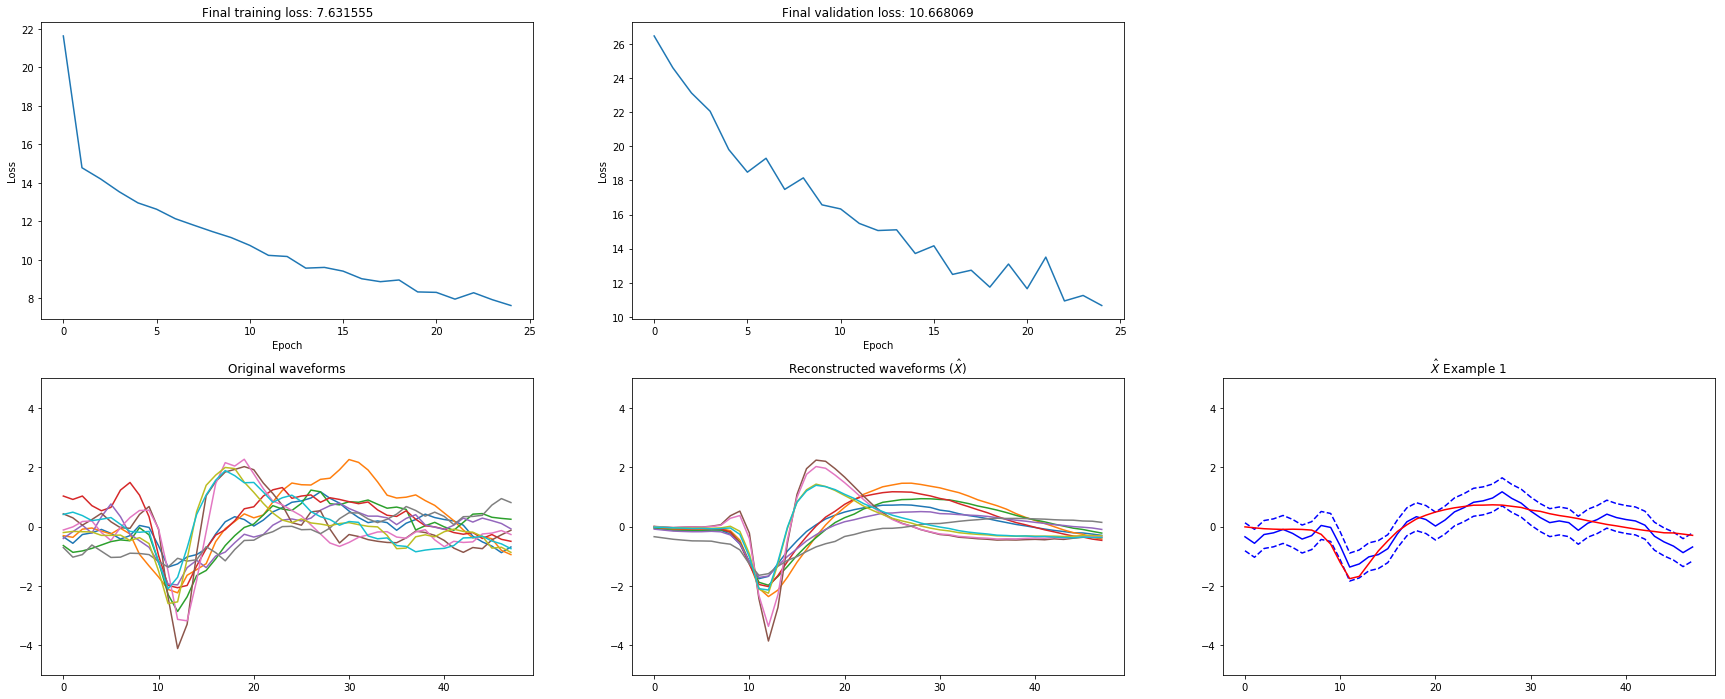

In [159]:
# Plot Loss results
fig = plt.figure(figsize=(30,12), facecolor='white')
plt.subplot(231)
plt.plot([x for x in train_loss])
plt.title('Final training loss: ' + str(train_loss[-1]))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(232)
plt.plot([x for x in valid_loss])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final validation loss: ' + str(valid_loss[-1]))

# Plot reconstruction examples
n_to_plot = 10

examples = get_examples(n_to_plot, ADD_NOISE)
  
m, logvar = model.encode(examples)
x_hat = model.decode(m)

lims = (-5,5)
diffs = np.sqrt(valid_loss[-1]/examples.shape[1])
print('Average error per point: ' + str(diffs))
plt.subplot(234)
plt.plot(examples.squeeze().T)
plt.title('Original waveforms')
plt.ylim(lims)
plt.subplot(235)
plt.plot(x_hat.numpy().squeeze().T)
plt.ylim(lims)
plt.title('Reconstructed waveforms ($\hat{X}$)');
plt.subplot(236)
plt.ylim(lims)
plt.plot(examples[0,:,:].squeeze(), 'b')
plt.plot(examples[0,:,:].squeeze()-diffs, '--b')
plt.plot(examples[0,:,:].squeeze()+diffs, '--b')
plt.plot(x_hat[0,:,:].numpy().squeeze(), 'r');
plt.title('$\hat{X}$ Example 1');

We can see that the above reconstructed waveforms seem pretty good. Which is expected since it is a very simple task. 

But keep in mind we have a very narrow bottleneck!

In [12]:
model.latent_dim

2

### Let's compare with PCA

Using the same script as above but for 1000 spikes. 

The color scale follows the values of the first PC. 

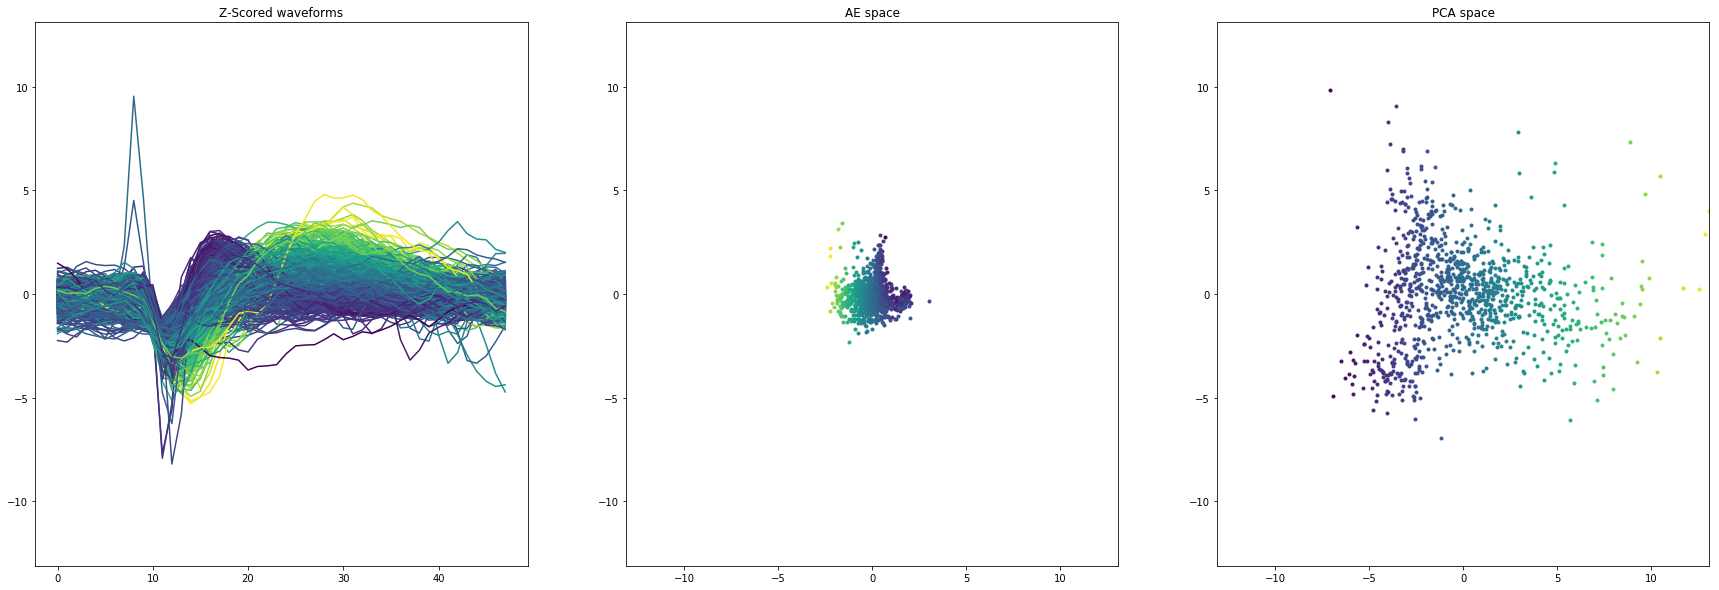

In [160]:
# Plot reconstruction examples
# Our AE
n_dim = model.latent_dim  # 2 by default

n_to_plot = 1000
examples = get_examples(n_to_plot, ADD_NOISE)
model_out, _ = model.encode(examples)

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=n_dim)
pca_out = pca.fit_transform(examples.squeeze())

min_pca = np.min(pca_out[:,0])
max_pca = np.max(pca_out[:,0])

from matplotlib import cm

# Plot results
lims = np.max(
          (np.abs(np.min(pca_out)), np.abs(np.max(pca_out)),
           np.abs(np.min(model_out)), np.abs(np.max(model_out))))

fig = plt.figure(figsize=(30,10), facecolor='white')
ax1 = plt.subplot(131, ylim=(-lims, lims), title='Z-Scored waveforms')
ax2 = plt.subplot(132, xlim=(-lims, lims), ylim=(-lims, lims), title='AE space')
#ax2 = plt.subplot(132, title='AE space')
ax3 = plt.subplot(133, xlim=(-lims, lims), ylim=(-lims, lims), title='PCA space')

for idx, ex in enumerate(examples.squeeze()):
  colors = cm.viridis((pca_out[idx,0] - np.min(pca_out))/(np.abs(np.min(pca_out))+np.max(pca_out)))
  ax1.plot(ex, color=colors)
  ax2.plot(model_out.numpy()[idx,0],model_out.numpy()[idx,1], '.', color=colors)
  ax3.plot(pca_out[idx,0],pca_out[idx,1], '.', color=colors)

The AE latent space is more spread out than the PCA one, and it seems that the two PC dimensions are mingled in the AE representations.

The AE feature space is also quite discontinuous meaning that when randomly sampling points to generate waveforms, there is a greater probability of sampling from an empty region which could yield an unrealistic or distorted waveform. 

Let generate a few and see. 


VAE generating in the range: 
 x:-2.3959246 to 3.0315971
 y:-2.2997928 to 3.4207292
VAE generated samples : 
 [[ 0.32017562 -0.55567149]
 [ 0.67243614  1.94035759]
 [ 1.7124431   3.08170532]
 [-0.01191447 -1.00370621]
 [ 0.65303367 -2.02931878]
 [-1.32480186  2.01316493]
 [ 0.72619412 -2.1571855 ]
 [ 1.01626184  0.73975115]
 [ 1.53203956  0.27918674]
 [ 2.57603568  3.11055403]]

PCA generating in the range: 
 x:-7.1054597 to 13.110372
 y:-7.1054597 to 9.842693
VAE generated samples : 
 [[ 3.01116949 -1.82142418]
 [ 4.32323047  5.50026672]
 [ 8.19693321  8.84822262]
 [ 1.7742371  -3.13566035]
 [ 4.25096229 -6.14412621]
 [-3.11586044  5.71383508]
 [ 4.52346224 -6.5192022 ]
 [ 5.60387433  1.97848513]
 [ 7.52498609  0.62749518]
 [11.4135472   8.93284559]]



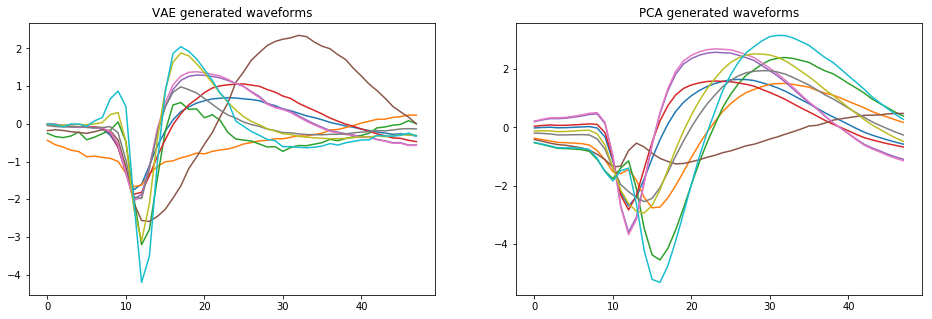

In [165]:
# Model_out feature space
min_model_x = np.min(model_out.numpy()[:,0])
max_model_x = np.max(model_out.numpy()[:,0])
min_model_y = np.min(model_out.numpy()[:,1])
max_model_y = np.max(model_out.numpy()[:,1])
print('VAE generating in the range: \n x:' +
      str(min_model_x) + ' to ' + str(max_model_x) + '\n y:' +
      str(min_model_y) + ' to ' + str(max_model_y))

n_to_generate=10
random_latent_features = np.random.rand(n_to_generate, 2)
model_latent = random_latent_features * np.array(((np.abs(min_model_x) + np.abs(max_model_x)),(np.abs(min_model_y) + np.abs(max_model_y))))
model_latent -= np.array((np.abs(min_model_x), np.abs(min_model_y)))
print('VAE generated samples : \n ' + str(model_latent) + '\n')

x_hat = model.decode(model_latent)

fig = plt.figure(figsize=(16,5), facecolor='white')
plt.subplot(121)
plt.plot(x_hat.numpy().squeeze().T)
plt.title('VAE generated waveforms');

# Repeat for PCA
min_pca_x = np.min(pca_out[:,0])
max_pca_x = np.max(pca_out[:,0])
min_pca_y = np.min(pca_out[:,1])
max_pca_y = np.max(pca_out[:,1])
print('PCA generating in the range: \n x:' +
      str(min_pca_x) + ' to ' + str(max_pca_x) + '\n y:' +
      str(min_pca_x) + ' to ' + str(max_pca_y))

pca_latent_features = random_latent_features * np.array(((np.abs(min_pca_x) + np.abs(max_pca_x)),(np.abs(min_pca_y) + np.abs(max_pca_y))))
pca_latent_features -= np.array((np.abs(min_pca_x), np.abs(min_pca_y)))
print('VAE generated samples : \n ' + str(pca_latent_features) + '\n')

pca_hat = pca.inverse_transform(pca_latent_features)

plt.subplot(122)
plt.plot(pca_hat.T)
plt.title('PCA generated waveforms');

# Implementation 2

### Possible to increase density in latent space? 

We can add a penalty term to our reconstruction loss function to force a specific latent representation. 

For example, we can force the latent variables to follow a unit Gaussian shape. ($\beta=1$)

Wich is a **Variational Auto-Encoder**.



If we re-run the cells above to re-plot, we see that the VAE latent representation is much more compact. This allows us to have a uniform latent space in order to generate believable waveforms. 




In [0]:
# Model parameters
BETA = 1.
BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 25

# Model Creation
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []

train_model(ADD_NOISE)

# Implementation 3

Last example is the **$\beta$-VAE**

By increasing the value for the $\beta$ parameter, this should force the learned latent features to be even more decorrelated. 

In [111]:
# Model parameters
BETA = 4.
BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 25

# Model Creation
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []

train_model(ADD_NOISE)


Epoch: 1, Train set loss: 26.575315475463867, Test set loss: 17.637256622314453, time elapsed for current epoch 2.185851812362671
Epoch: 2, Train set loss: 17.365007400512695, Test set loss: 17.022092819213867, time elapsed for current epoch 1.9171490669250488
Epoch: 3, Train set loss: 17.198640823364258, Test set loss: 17.059410095214844, time elapsed for current epoch 1.938286542892456
Epoch: 4, Train set loss: 17.103137969970703, Test set loss: 16.87417221069336, time elapsed for current epoch 1.9341251850128174
Epoch: 5, Train set loss: 16.953163146972656, Test set loss: 16.69943618774414, time elapsed for current epoch 1.9288249015808105
Epoch: 6, Train set loss: 16.941951751708984, Test set loss: 16.658666610717773, time elapsed for current epoch 1.908013105392456
Epoch: 7, Train set loss: 16.83338737487793, Test set loss: 16.647323608398438, time elapsed for current epoch 1.917024850845337
Epoch: 8, Train set loss: 16.867286682128906, Test set loss: 16.47906494140625, time elaps

# Implementation 4

In this section we will use the capacity parameter and linearly increase it with training to for the network to learn disentangled representations. 

This is taken from [Burgess et al.,2018](http://arxiv.org/abs/1804.03599).

In a nutshell, by using a large $\beta$ value, the network prioritizes the KL divergence term of the loss function and doesn't learn to reconstruct the data at the beginning of training (i.e. capacity = 0). It basically models the data mean. 

The capacity term is added to the loss function where: 

$Loss = Reconstruction \space loss + \beta (KL \space divergence - capacity)$

This means that when we increase the capacity of the network, we slowly reduce the importance of the KL divergence term, allowing the network to slowly increase it's reconstruction capacity. 

The followin cell plots the latent space of a few example waveforms. Throught training we can see that the network first separates the data along one dimension, and later along the second one. 

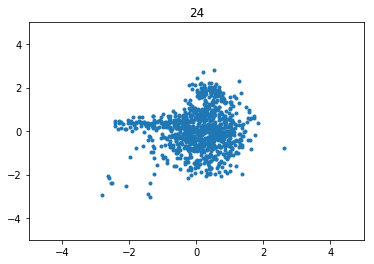

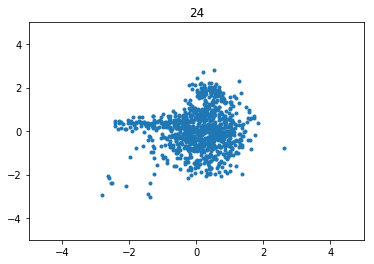

In [32]:
from IPython import display
import time
# Model Creation
# Model parameters
BETA = 20.  # actually gamma parameter in the paper
CAPACITY_MAX = 2
CAPACITY_ANN = 25
CAPACITY_STEP = 1

BATCH_SIZE = 1024  
LEARNING_RATE = 1e-2
EPOCHS = 1
model = betaCVAE(learning_rate=LEARNING_RATE, beta=BETA, capacity=0., latent_dim=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Trackers
train_loss = []
valid_loss = []
train_time = []
valid_time = []
recon_loss = []
latent_loss = []

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
line = ax.plot(0,0,'.')

n_to_plot = 1000
examples = get_examples(n_to_plot, ADD_NOISE)

for x in range(0,CAPACITY_ANN):
  if x % CAPACITY_STEP == 0 and x > 0:
    model.capacity += CAPACITY_MAX / (CAPACITY_ANN / CAPACITY_STEP)
  
  train_model(ADD_NOISE, out_losses=True);
  test = model.encode(examples)[0].numpy().squeeze()
  line[0].set_xdata(test[:,0])
  line[0].set_ydata(test[:,1])
  ax.set_title(str(x))
  display.clear_output()
  display.display(plt.gcf())
  time.sleep(.001) 
  

In the paper $\beta$ is renamed $\gamma$ and capacity is defined as C. 

**How to Tune Hyperparameters Gamma and C? (Response by Christopher P. Burgess)**

Gamma sets the strength of the penalty for deviating from the target KL, C. Here you want to tune this such that the (batch) average KL stays close to C (say within < 1 nat) across the range of C that you use. This exact value doesn't usually matter much, but just avoid it being too high such that it destabilises the optimisation. C itself should start from low (e.g. 0 or 1) and gradually increase to a value high enough such that reconstructions end up good quality. A good way to estimate Cmax is to train B-VAE on your dataset with a beta low enough such that reconstructions end up good quality and look at the trained model's average KL. That KL can be your Cmax because it gives you a rough guide as to the average amount of representational capacity needed to encode your dataset.
